In [3]:
import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, Aer, IBMQ
from qiskit.tools.visualization import circuit_drawer
from qiskit.tools.monitor import job_monitor, backend_monitor, backend_overview
from qiskit.providers.aer import noise

import matplotlib.pyplot as plt
import numpy as np
import time

provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-11-20 16:12:02,132: Credentials are already in use. The existing account in the session will be replaced.


In [4]:
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
quito = provider.get_backend('ibmq_quito')

ibmqfactory.load_account:WARNING:2022-11-20 16:14:54,724: Credentials are already in use. The existing account in the session will be replaced.


In [5]:
sim = Aer.get_backend('aer_simulator')

In [6]:
def makeCHSHcircuit(thetavec):

    chsh_circuits = []
    
    for theta in thetavec:
        obs_vec = ['00', '01', '10', '11']
        for el in obs_vec:
            qc = QuantumCircuit(2,2)
            qc.h(0)
            qc.cx(0, 1)
            qc.ry(theta, 0)
            for a in range(2):
                if el[a] == '1':
                    qc.h(a) 
            qc.measure(range(2),range(2))
            chsh_circuits.append(qc)

    return chsh_circuits

In [7]:
def compute_chsh_witness(counts):
    
    CHSH1 = []
    CHSH2 = []
    for i in range(0, len(counts), 4):  
        theta_dict = counts[i:i + 4]
        zz = theta_dict[0]
        zx = theta_dict[1]
        xz = theta_dict[2]
        xx = theta_dict[3]

        no_shots = sum(xx[y] for y in xx)

        chsh1 = 0
        chsh2 = 0

        for element in zz:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1+= parity*zz[element]
            chsh2+= parity*zz[element]

        for element in zx:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1+= parity*zx[element]
            chsh2-= parity*zx[element]

        for element in xz:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1-= parity*xz[element]
            chsh2+= parity*xz[element]

        for element in xx:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1+= parity*xx[element]
            chsh2+= parity*xx[element]

        CHSH1.append(chsh1/no_shots)
        CHSH2.append(chsh2/no_shots)
    
    return CHSH1, CHSH2


In [9]:
number_of_thetas = 20
theta_vec = np.linspace(0,2*np.pi,number_of_thetas)
my_chsh_circuits = makeCHSHcircuit(theta_vec)

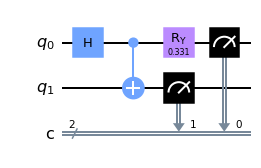

In [10]:
my_chsh_circuits[4].draw()

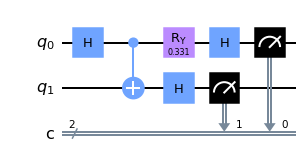

In [11]:
my_chsh_circuits[7].draw()

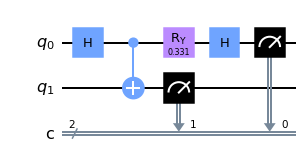

In [12]:
my_chsh_circuits[6].draw()

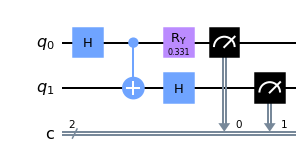

In [13]:
my_chsh_circuits[5].draw()

In [ ]:
result_ideal = sim.run(my_chsh_circuits).result()

tic = time.time()
transpiled_circuits = transpile(my_chsh_circuits, quito)
job_real = quito.run(transpiled_circuits, shots=8192)
job_monitor(job_real)
result_real = job_real.result()
toc = time.time()

print(toc-tic)


In [15]:
CHSH1_ideal, CHSH2_ideal = compute_chsh_witness(result_ideal.get_counts())
CHSH1_real, CHSH2_real = compute_chsh_witness(result_real.get_counts())


Traceback (most recent call last):
  Input In [15] in <cell line: 2>
    CHSH1_real, CHSH2_real = compute_chsh_witness(result_real.get_counts())
NameError: name 'result_real' is not defined

Use %tb to get the full traceback.


In [ ]:
plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 22})
plt.plot(theta_vec,CHSH1_ideal,'o-',label = 'CHSH1 Noiseless')
plt.plot(theta_vec,CHSH2_ideal,'o-',label = 'CHSH2 Noiseless')

plt.plot(theta_vec,CHSH1_real,'x-',label = 'CHSH1 Quito')
plt.plot(theta_vec,CHSH2_real,'x-',label = 'CHSH2 Quito')

plt.grid(which='major',axis='both')
plt.rcParams.update({'font.size': 16})
plt.legend()
plt.axhline(y=2, color='r', linestyle='-')
plt.axhline(y=-2, color='r', linestyle='-')
plt.axhline(y=np.sqrt(2)*2, color='k', linestyle='-.')
plt.axhline(y=-np.sqrt(2)*2, color='k', linestyle='-.')
plt.xlabel('Theta')
plt.ylabel('CHSH witness')